## Deep Learning Study for Image Classification of Alzheimer's MRI

Author: Simone Castelli

cstsmn.job@gmail.com

20 May 2025

### Introduction

The dataset utilized for this research is the “Alzheimer MRI Disease Classification Dataset” by BorhaniTrash (2021), available on Kaggle. This dataset is updated quarterly, and I will provide insights on the class distribution at a later stage. Retrieved from https://www.kaggle.com/datasets/borhanitrash/alzheimer-mri-disease-classification-dataset

### Exploratory Data Analysis


In [ ]:
# 1. Standard Libraries
import os
import platform
import random
import time
import zipfile
from io import StringIO

# 2. Data Analysis Libraries
import numpy as np
import pandas as pd

# 3. Machine Learning and Deep Learning Libraries
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras import backend as K
from tensorflow.keras.applications import ResNet50, VGG16
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import (
    BatchNormalization, Conv2D, Dense, Dropout, Flatten, Input, MaxPooling2D
)
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    f1_score, precision_score, recall_score
)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample

# 4. Image Processing Libraries
import cv2

# 5. File Handling and Integration Libraries
import kagglehub
from google.colab import files

# 6. Visualization Libraries
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns

# 7. System Monitoring and Utilities
import psutil

In [ ]:
def get_system_info():
    print("--- System Information ---")
    print(f"Operating System: {platform.system()} {platform.release()}")
    print(f"CPU Cores: {psutil.cpu_count(logical=True)} logical")

    # RAM info
    memory_info = psutil.virtual_memory()
    print(f"Total RAM: {memory_info.total / 1e9:.2f} GB")
    print(f"Available RAM: {memory_info.available / 1e9:.2f} GB")

if __name__ == "__main__":
    get_system_info()

--- System Information ---
Operating System: Linux 6.1.85+
CPU Cores: 2 logical
Total RAM: 13.61 GB
Available RAM: 11.98 GB


In [ ]:
# Download the latest version of the dataset
path = kagglehub.dataset_download("borhanitrash/alzheimer-mri-disease-classification-dataset")

print("Path to dataset files:", path)

100%|██████████| 26.0M/26.0M [00:00<00:00, 30.3MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/borhanitrash/alzheimer-mri-disease-classification-dataset/versions/1


In [ ]:
# Alzheimer MRI Disease Classification: Label Mapping
disease_label_from_category = {
    0: "Mild Demented",
    1: "Moderate Demented",
    2: "Non Demented",
    3: "Very Mild Demented",
}

In [ ]:
# Check the structure of the downloaded files
print("Listing contents of dataset path:")
print(os.listdir(path))

# Construct file path based on the structure
parquet_file_path = f"{path}/Alzheimer MRI Disease Classification Dataset/Data/train-00000-of-00001-c08a401c53fe5312.parquet"

# Check if the file exists and read it
if os.path.exists(parquet_file_path):
    # Read the Parquet file into a DataFrame
    df = pd.read_parquet(parquet_file_path)

    # Display the first few rows of the DataFrame
    print(df.head())
else:
    print(f"File not found: {parquet_file_path}")

Listing contents of dataset path:
['Alzheimer MRI Disease Classification Dataset']
                                               image  label
0  {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...      2
1  {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...      0
2  {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...      3
3  {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...      3
4  {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...      2


In [ ]:
# Show a concise summary of the DataFrame
print("Dataframe Info:")
print(df.info())

Dataframe Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5120 entries, 0 to 5119
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   5120 non-null   object
 1   label   5120 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 80.1+ KB
None


In [ ]:
# Converts a dictionary containing image bytes to a grayscale image using OpenCV
def dict_to_image(image_dict):
    if isinstance(image_dict, dict) and 'bytes' in image_dict:
        byte_string = image_dict['bytes']
        nparr = np.frombuffer(byte_string, np.uint8)
        img = cv2.imdecode(nparr, cv2.IMREAD_GRAYSCALE)
        return img
    else:
        raise TypeError(f"Expected dictionary with 'bytes' key, got {type(image_dict)}")

In [ ]:
# Applies the 'dict_to_image' function to the 'image' column and processes the data
df['img_arr'] = df['image'].apply(dict_to_image)
df.drop("image", axis=1, inplace=True)
df.head()

,label,img_arr
0,2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
1,0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
2,3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
3,3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
4,2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."


In [ ]:
# Extract and display the resolution of each image
resolutions = df['img_arr'].apply(lambda img: img.shape if img is not None else None)

# Add resolutions as a new column for better accessibility
df['resolution'] = resolutions

# Display unique resolutions and count of images for each resolution
resolution_counts = df['resolution'].value_counts()

print("Unique image resolutions and their counts:")
print(resolution_counts)

# Display a sample of resolutions
print("\nSample of image resolutions:")
print(df[['resolution']].head())

Unique image resolutions and their counts:
resolution
(128, 128)    5120
Name: count, dtype: int64

Sample of image resolutions:
   resolution
0  (128, 128)
1  (128, 128)
2  (128, 128)
3  (128, 128)
4  (128, 128)


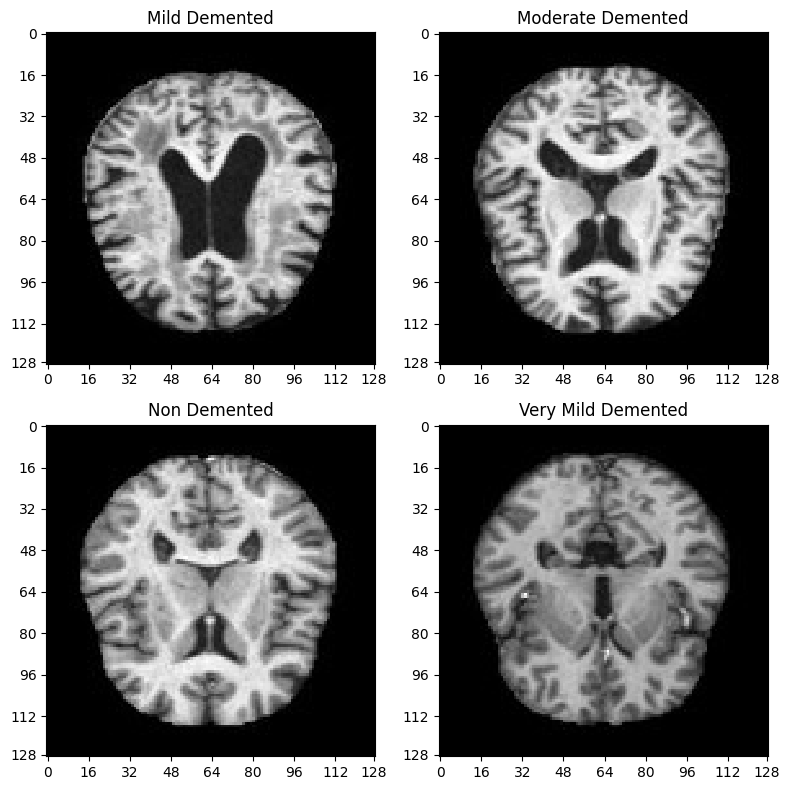

In [ ]:
# Displays each image on a separate subplot with pixel values on the axes
fig, ax = plt.subplots(2, 2, figsize=(8, 8))
axs = ax.flatten()

multiples_of_16 = list(range(0, 128, 16))

for i, label in enumerate(disease_label_from_category.values()):
    label_df = df[df['label'] == i]
    if not label_df.empty:
        img_data = label_df.sample(1).iloc[0]

        axs[i].imshow(img_data['img_arr'], cmap="gray", interpolation='nearest')
        axs[i].set_title(label)
        axs[i].axis('on')
        axs[i].set_aspect('auto')
        x_ticks = multiples_of_16
        y_ticks = multiples_of_16
        if x_ticks[-1] != img_data['img_arr'].shape[1] - 1:
            x_ticks = x_ticks + [img_data['img_arr'].shape[1] - 1]
        if y_ticks[-1] != img_data['img_arr'].shape[0] - 1:
            y_ticks = y_ticks + [img_data['img_arr'].shape[0] - 1]
        x_tick_labels = [str(tick) if tick != img_data['img_arr'].shape[1] - 1 else '128' for tick in x_ticks]
        y_tick_labels = [str(tick) if tick != img_data['img_arr'].shape[0] - 1 else '128' for tick in y_ticks]

        axs[i].set_xticks(x_ticks)
        axs[i].set_xticklabels(x_tick_labels)
        axs[i].set_yticks(y_ticks)
        axs[i].set_yticklabels(y_tick_labels)

# Clear unused axes (if fewer labels exist)
for ax in axs[len(disease_label_from_category):]:
    ax.axis('off')

plt.tight_layout()
plt.savefig('fig_01.png', format='png', dpi=300)
plt.show()

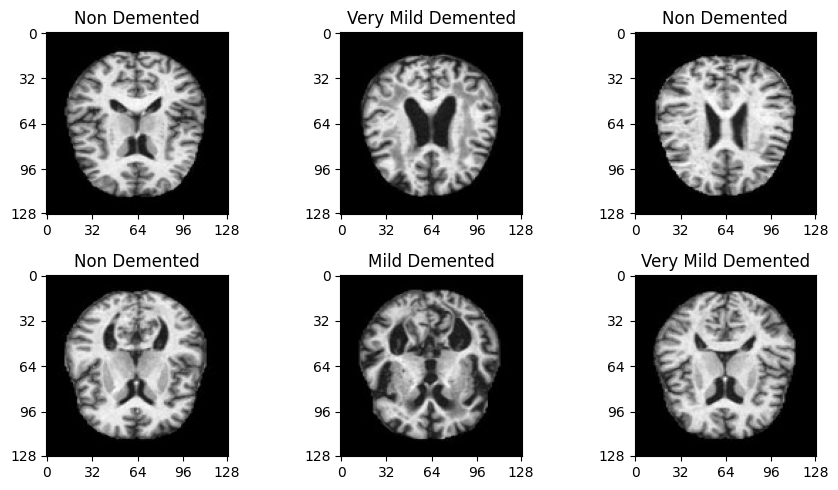

In [ ]:
# Displays a grid of random images from the dataframe with their corresponding disease labels
fig, ax = plt.subplots(2, 3, figsize=(9, 5))
axs = ax.flatten()

for axes in axs:
    rand_idx = np.random.randint(0, len(df))
    img_data = df.iloc[rand_idx]
    axes.imshow(img_data['img_arr'], cmap="gray")
    axes.set_title(disease_label_from_category[img_data['label']])

    # Define ticks as before
    x_ticks = np.arange(0, img_data['img_arr'].shape[1], 32)
    y_ticks = np.arange(0, img_data['img_arr'].shape[0], 32)

    if x_ticks[-1] != img_data['img_arr'].shape[1] - 1:
        x_ticks = np.append(x_ticks, img_data['img_arr'].shape[1] - 1)
    if y_ticks[-1] != img_data['img_arr'].shape[0] - 1:
        y_ticks = np.append(y_ticks, img_data['img_arr'].shape[0] - 1)

    x_tick_labels = [str(tick) if tick != img_data['img_arr'].shape[1] - 1 else '128' for tick in x_ticks]
    y_tick_labels = [str(tick) if tick != img_data['img_arr'].shape[0] - 1 else '128' for tick in y_ticks]

    axes.set_xticks(x_ticks)
    axes.set_xticklabels(x_tick_labels)
    axes.set_yticks(y_ticks)
    axes.set_yticklabels(y_tick_labels)

plt.tight_layout()
plt.savefig('fig_02.png', format='png', dpi=300)
plt.show()

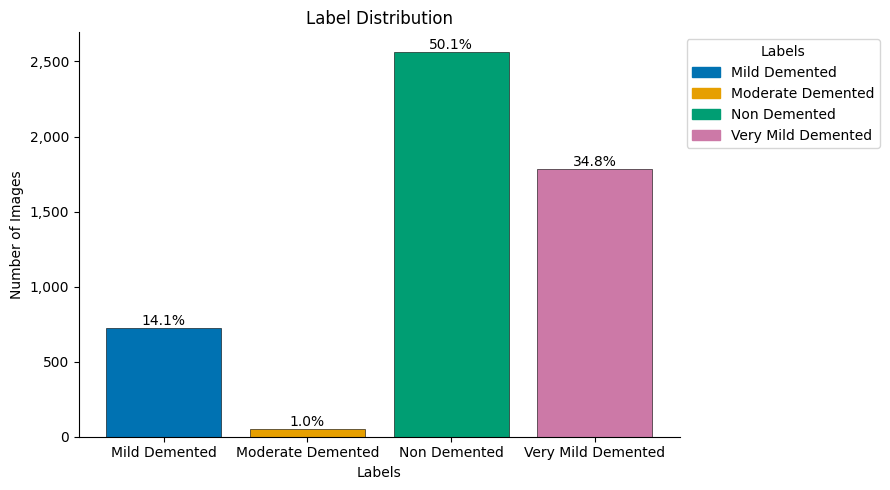

In [ ]:
# Plots a bar chart showing the distribution of labels in the dataset
plt.figure(figsize=(9, 5))

label_counts = df['label'].value_counts().sort_index()
total_images = label_counts.sum()

shades = ['#0072B2', '#E69F00', '#009E73', '#CC79A7']
labels = [disease_label_from_category[i] for i in range(4)]
bars = plt.bar(np.arange(0, 4, 1), label_counts, color=shades, edgecolor='black', linewidth=0.4)

plt.ylabel("Number of Images")
plt.xlabel("Labels")  # Added x-axis label
plt.xticks(np.arange(0, 4, 1), labels=labels)
plt.gca().get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
plt.title("Label Distribution")
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Adding percentage labels on top of bars
for bar, count in zip(bars, label_counts):
    percentage = (count / total_images) * 100
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f"{percentage:.1f}%",
             ha='center', va='bottom', fontsize=10)

# Adding legend outside the graph, at the top right
plt.legend(handles=[plt.Rectangle((0,0),1,1, color=shades[i]) for i in range(4)],
           labels=labels, title="Labels", loc='upper left', bbox_to_anchor=(1, 1))

plt.tight_layout()
plt.savefig('fig_03.png', format='png', dpi=300, bbox_inches='tight')
plt.show()

### Data preprocessing

In [ ]:
# Original disease labels
disease_label_from_category = {
    0: "Mild Demented",
    1: "Moderate Demented",
    2: "Non Demented",
    3: "Very Mild Demented",
}

# Recoding logic
label_mapping = {}
for key, value in disease_label_from_category.items():
    if value in ["Mild Demented", "Moderate Demented", "Very Mild Demented"]:
        label_mapping[key] = 1  # Early Alzheimer
    elif value == "Non Demented":
        label_mapping[key] = 0  # No Alzheimer

# Output the transformed mapping
for key, value in label_mapping.items():
    if value == 1:
        print(f"{key}: {value},  # Early Alzheimer")
    else:
        print(f"{key}: {value},  # No Alzheimer")

0: 1,  # Early Alzheimer
1: 1,  # Early Alzheimer
2: 0,  # No Alzheimer
3: 1,  # Early Alzheimer


In [ ]:
# Apply label mapping to create a binary_label column
df['binary_label'] = df['label'].map(label_mapping)

# Count the occurrences of each binary label (0 and 1)
binary_label_counts = df['binary_label'].value_counts()
binary_label_counts

,count
binary_label,
0,2566
1,2554


In [ ]:
# Display the first five rows of the DataFrame
df.head()

,label,img_arr,resolution,binary_label
0,2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","(128, 128)",0
1,0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","(128, 128)",1
2,3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","(128, 128)",1
3,3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","(128, 128)",1
4,2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","(128, 128)",0


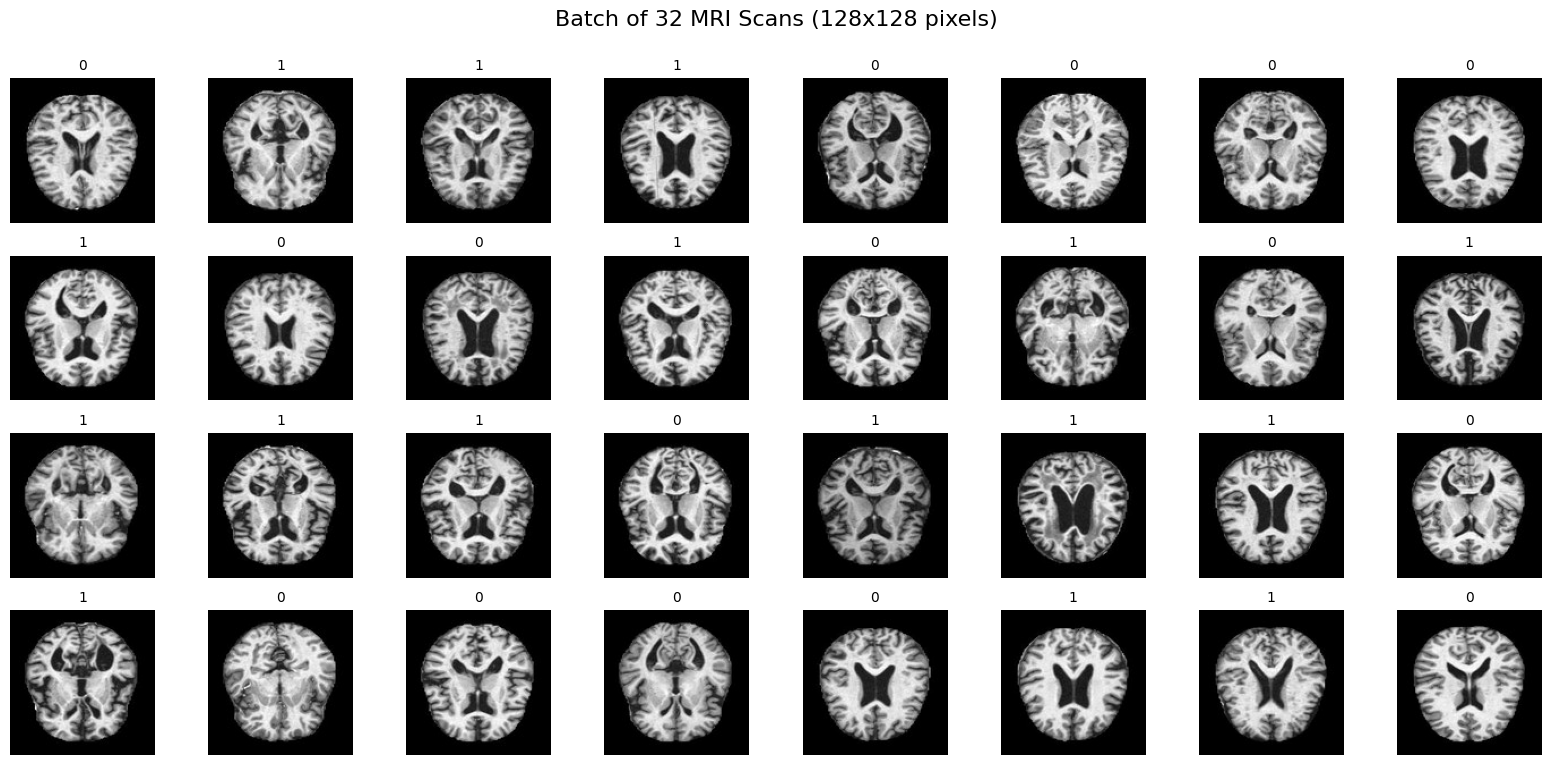

In [ ]:
# Select a batch of 32 images and their binary labels
batch_size = 32
batch_images = df['img_arr'][:batch_size]
batch_labels = df['binary_label'][:batch_size]

# Create a figure for plotting
fig, axes = plt.subplots(4, 8, figsize=(16, 8))
fig.suptitle("Batch of 32 MRI Scans (128x128 pixels)", fontsize=16, y=0.95)

# Iterate over the batch and plot images with labels
for idx, (img, label) in enumerate(zip(batch_images, batch_labels)):
    row = idx // 8
    col = idx % 8
    axes[row, col].imshow(img, cmap='gray')
    axes[row, col].set_title(f"{label}", fontsize=10)
    axes[row, col].axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig('fig_04.png', format='png', dpi=300)
plt.show()

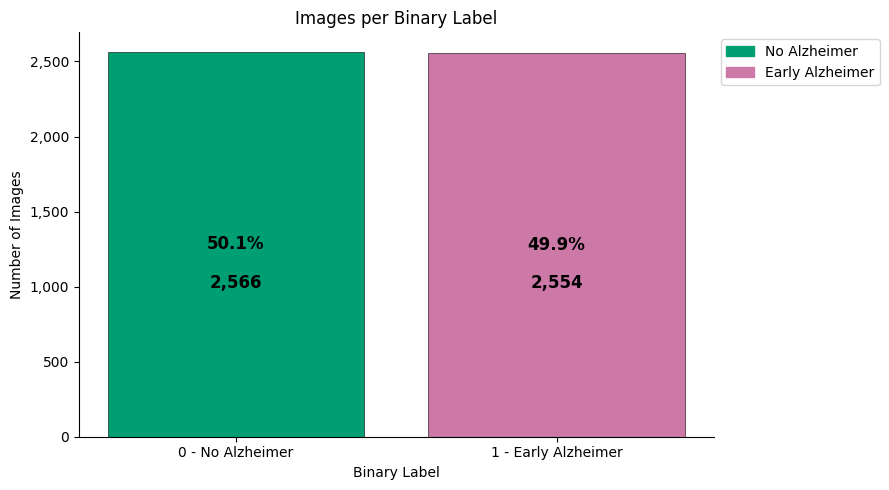

In [ ]:
# Calculate percentages for each label
total_images = sum(binary_label_counts)
percentages = [(count / total_images * 100) for count in binary_label_counts]

# Define colors
colors = ['#009E73', '#CC79A7']

# Create the bar chart
plt.figure(figsize=(9, 5))
bars = plt.bar(range(len(binary_label_counts)), binary_label_counts, color=colors, edgecolor=['black', 'black'], linewidth=[0.4, 0.4])

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Default text color is black
text_color = 'black'

# Add percentage and count labels
for bar, percentage, count in zip(bars, percentages, binary_label_counts):
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() / 2,
        f"{percentage:.1f}%",
        ha='center', va='center', color=text_color, fontsize=12, fontweight='bold'
    )

    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() / 2 - bar.get_height() * 0.1,
        f"{count:,}",
        ha='center', va='center', color=text_color, fontsize=12, fontweight='bold'
    )

plt.xlabel('Binary Label')
plt.ylabel('Number of Images')
plt.title('Images per Binary Label')

plt.gca().yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}'))
plt.xticks([0, 1], labels=['0 - No Alzheimer', '1 - Early Alzheimer'])

# Add legend
legend_handles = [plt.Rectangle((0, 0), 1, 1, color=colors[i]) for i in range(2)]
plt.legend(
    handles=legend_handles,
    labels=['No Alzheimer', 'Early Alzheimer'],
    loc='upper left',
    bbox_to_anchor=(1, 1)
)

# Adjust layout and save
plt.tight_layout()
plt.savefig('fig_05.png', format='png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# Split Data Frame ensuring the class distribution is maintained
train_df, temp_df = train_test_split(df, test_size=0.4, stratify=df['binary_label'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['binary_label'], random_state=42)

# Print the size of each split
print("Training set size:", train_df.shape[0])
print("Validation set size:", val_df.shape[0])
print("Test set size:", test_df.shape[0])

Training set size: 3072
Validation set size: 1024
Test set size: 1024


In [ ]:
# Verify the distribution of labels in each set
print("\nTraining set label distribution:")
print(train_df['binary_label'].value_counts(normalize=True))
print("\nValidation set label distribution:")
print(val_df['binary_label'].value_counts(normalize=True))
print("\nTest set label distribution:")
print(test_df['binary_label'].value_counts(normalize=True))


Training set label distribution:
binary_label
0    0.501302
1    0.498698
Name: proportion, dtype: float64

Validation set label distribution:
binary_label
0    0.500977
1    0.499023
Name: proportion, dtype: float64

Test set label distribution:
binary_label
0    0.500977
1    0.499023
Name: proportion, dtype: float64


In [ ]:
# Separate majority and minority classes
majority_class = train_df[train_df['binary_label'] == train_df['binary_label'].value_counts().idxmax()]
minority_class = train_df[train_df['binary_label'] == train_df['binary_label'].value_counts().idxmin()]

# Oversample the minority class
minority_class_oversampled = resample(minority_class,
                                      replace=True,  # Allow duplicate samples
                                      n_samples=majority_class.shape[0],  # Match majority class size
                                      random_state=42)

# Combine the oversampled minority class with the majority class
balanced_train_df = pd.concat([majority_class, minority_class_oversampled])

# Shuffle the dataset
balanced_train_df = balanced_train_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Print the size and distribution
print("Balanced Training set size:", balanced_train_df.shape[0])
print("Balanced Training set label distribution:")
print(balanced_train_df['binary_label'].value_counts(normalize=True))

Balanced Training set size: 3080
Balanced Training set label distribution:
binary_label
0    0.5
1    0.5
Name: proportion, dtype: float64


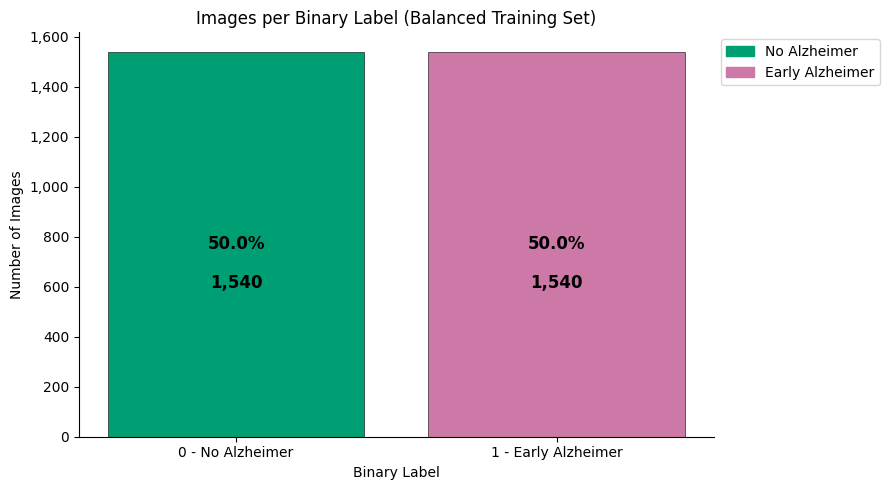

In [ ]:
# Calculate percentages for each label in the balanced training set
binary_label_counts_balanced = balanced_train_df['binary_label'].value_counts()
total_images_balanced = binary_label_counts_balanced.sum()
percentages_balanced = [(count / total_images_balanced * 100) for count in binary_label_counts_balanced]

# Define colors
colors = ['#009E73', '#CC79A7']

# Create the bar chart
plt.figure(figsize=(9, 5))
bars = plt.bar(range(len(binary_label_counts_balanced)), binary_label_counts_balanced, color=colors, edgecolor=['black', 'black'], linewidth=[0.4, 0.4])

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Set all text color to black
text_color = 'black'

# Add percentage and count labels
for bar, percentage, count in zip(bars, percentages_balanced, binary_label_counts_balanced):
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() / 2,
        f"{percentage:.1f}%",
        ha='center', va='center', color=text_color, fontsize=12, fontweight='bold'
    )

    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() / 2 - bar.get_height() * 0.1,
        f"{count:,}",
        ha='center', va='center', color=text_color, fontsize=12, fontweight='bold'
    )

plt.xlabel('Binary Label')
plt.ylabel('Number of Images')
plt.title('Images per Binary Label (Balanced Training Set)')

plt.gca().yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}'))
plt.xticks([0, 1], labels=['0 - No Alzheimer', '1 - Early Alzheimer'])

# Add legend
legend_handles = [plt.Rectangle((0, 0), 1, 1, color=colors[i]) for i in range(2)]
plt.legend(
    handles=legend_handles,
    labels=['No Alzheimer', 'Early Alzheimer'],
    loc='upper left',
    bbox_to_anchor=(1, 1)
)

# Adjust layout and save
plt.tight_layout()
plt.savefig('fig_06.png', format='png', dpi=300, bbox_inches='tight')
plt.show()

### CNN - Convolutional Neural Network

In [ ]:
# Function to Clear Keras Session
K.clear_session()
print("Keras session cleared.")

Keras session cleared.


In [ ]:
# Preprocess images and labels: reshape, normalize, and one-hot encode.
input_shape = (128, 128, 1)

CNN_X_train = np.stack(balanced_train_df['img_arr'].values).reshape(-1, 128, 128, 1) / 255.0
CNN_y_train = to_categorical(balanced_train_df['binary_label'].values, num_classes=2)

CNN_X_val = np.stack(val_df['img_arr'].values).reshape(-1, 128, 128, 1) / 255.0
CNN_y_val = to_categorical(val_df['binary_label'].values, num_classes=2)

CNN_X_test = np.stack(test_df['img_arr'].values).reshape(-1, 128, 128, 1) / 255.0
CNN_y_test = to_categorical(test_df['binary_label'].values, num_classes=2)

In [ ]:
# Ensure that the data and labels for training, validation, and test sets have matching lengths
assert len(CNN_X_train) == len(CNN_y_train), "Training data and labels size mismatch!"
assert len(CNN_X_val) == len(CNN_y_val), "Validation data and labels size mismatch!"
assert len(CNN_X_test) == len(CNN_y_test), "Test data and labels size mismatch!"

In [ ]:
# Define the CNN model
CNN_model = Sequential([
    Input(shape=(128, 128, 1)),  # Adjusted input shape for 128x128 images
    Conv2D(32, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    Conv2D(128, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.25),
    Dense(2, activation='softmax')
])

In [ ]:
# Stop training if val_loss doesn't improve for 5 epochs
CNN_early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [ ]:
# Set optimizer, loss, and metrics for training.
CNN_model.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
# Print the model summary
CNN_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 126, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │       1,605,696 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,698,498 (6.48 MB)

 Trainable params: 1,698,498 (6.48 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Build the CNN Model
CNN_history = CNN_model.fit(
    CNN_X_train, CNN_y_train,
    validation_data=(CNN_X_val, CNN_y_val),
    epochs=60,
    batch_size=64,
    callbacks=[CNN_early_stopping],
    verbose=1
)

Epoch 1/60
49/49 ━━━━━━━━━━━━━━━━━━━━ 20s 171ms/step - accuracy: 0.5086 - loss: 0.7225 - val_accuracy: 0.5020 - val_loss: 0.6906
Epoch 2/60
49/49 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.5531 - loss: 0.6854 - val_accuracy: 0.6592 - val_loss: 0.6390
Epoch 3/60
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.6015 - loss: 0.6756 - val_accuracy: 0.6992 - val_loss: 0.5812
Epoch 4/60
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.6958 - loss: 0.5909 - val_accuracy: 0.7070 - val_loss: 0.5788
Epoch 5/60
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.7056 - loss: 0.5669 - val_accuracy: 0.7373 - val_loss: 0.5362
Epoch 6/60
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.7327 - loss: 0.5451 - val_accuracy: 0.7402 - val_loss: 0.5500
Epoch 7/60
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.7444 - loss: 0.5233 - val_accuracy: 0.7539 - val_loss: 0.5275
Epoch 8/60
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.7251 - loss: 0.5366 - val_accuracy: 0.7686 -

In [ ]:
# Evaluate the model on the test set
CNN_evaluation = CNN_model.evaluate(CNN_X_test, CNN_y_test, verbose=1)

# Extract loss and accuracy
CNN_test_loss, CNN_test_accuracy = CNN_evaluation[0], CNN_evaluation[1]

# Display the results in a formatted output
print(f"CNN Evaluation Results:")
print(f" - Test Loss: {CNN_test_loss:.4f}")
print(f" - Test Accuracy: {CNN_test_accuracy:.4f}")

32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9264 - loss: 0.2105
CNN Evaluation Results:
 - Test Loss: 0.2080
 - Test Accuracy: 0.9346


In [ ]:
# Extract train and validation metrics
CNN_train_loss = CNN_history.history['loss']
CNN_val_loss = CNN_history.history['val_loss']
CNN_train_accuracy = CNN_history.history['accuracy']
CNN_val_accuracy = CNN_history.history['val_accuracy']

# Display final train and validation metrics
print(f"CNN Training Loss: {CNN_train_loss[-1]:.4f}")
print(f"CNN Validation Loss: {CNN_val_loss[-1]:.4f}")
print(f"CNN Training Accuracy: {CNN_train_accuracy[-1]:.4f}")
print(f"CNN Validation Accuracy: {CNN_val_accuracy[-1]:.4f}")

CNN Training Loss: 0.0421
CNN Validation Loss: 0.1523
CNN Training Accuracy: 0.9867
CNN Validation Accuracy: 0.9561


In [ ]:
# Save the model
CNN_model.save('cnn_alzheimer_classifier.keras')

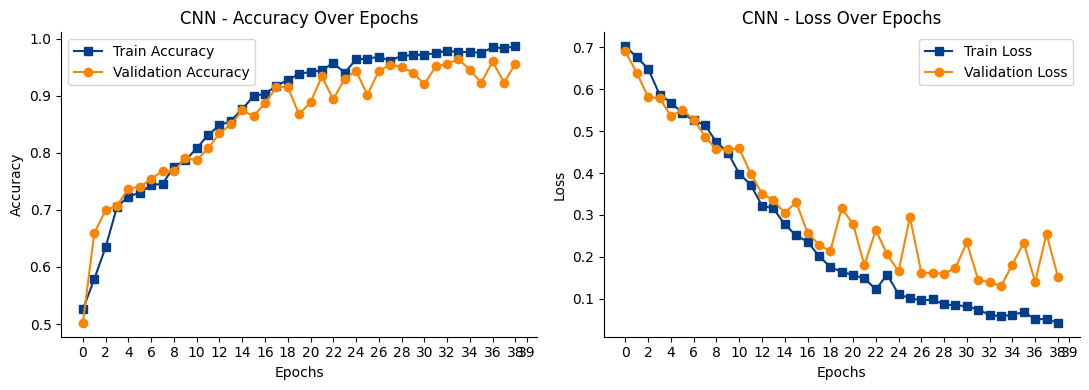

In [ ]:
# Create combined of CNN accuracy and loss
fig, axs = plt.subplots(1, 2, figsize=(11, 4))

# Plot accuracy
axs[0].plot(CNN_train_accuracy, label='Train Accuracy', marker='s', color='#023e8a')
axs[0].plot(CNN_val_accuracy, label='Validation Accuracy', marker='o', color='#fb8500')
axs[0].set_title('CNN - Accuracy Over Epochs')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Accuracy')
axs[0].legend()
axs[0].spines['top'].set_visible(False)
axs[0].spines['right'].set_visible(False)
epochs = range(1, len(CNN_history.history['loss']) + 1)
multiples_of_2 = [x for x in epochs if x % 2 == 0]
if 0 not in multiples_of_2:
    multiples_of_2 = [0] + multiples_of_2
if epochs[-1] not in multiples_of_2:
    multiples_of_2.append(epochs[-1])
axs[0].set_xticks(multiples_of_2)

# Plot loss
axs[1].plot(CNN_train_loss, label='Train Loss', marker='s', color='#023e8a')
axs[1].plot(CNN_val_loss, label='Validation Loss', marker='o', color='#fb8500')
axs[1].set_title('CNN - Loss Over Epochs')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Loss')
axs[1].legend()
axs[1].spines['top'].set_visible(False)
axs[1].spines['right'].set_visible(False)
axs[1].set_xticks(multiples_of_2)

plt.tight_layout()
plt.savefig('fig_07.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# Predict classes for the test set
CNN_y_pred = CNN_model.predict(CNN_X_test, verbose=1)
CNN_y_pred_classes = np.argmax(CNN_y_pred, axis=1)
CNN_y_true_classes = np.argmax(CNN_y_test, axis=1)

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


In [ ]:
# Generate CNN classification report
CNN_classification_report = classification_report(CNN_y_true_classes,CNN_y_pred_classes,target_names=['0 - No Alzheimer', '1 - Early Alzheimer'])
print("Classification Report for CNN:")
print(CNN_classification_report)

Classification Report for CNN:
                     precision    recall  f1-score   support

   0 - No Alzheimer       0.92      0.96      0.94       513
1 - Early Alzheimer       0.95      0.91      0.93       511

           accuracy                           0.93      1024
          macro avg       0.94      0.93      0.93      1024
       weighted avg       0.94      0.93      0.93      1024



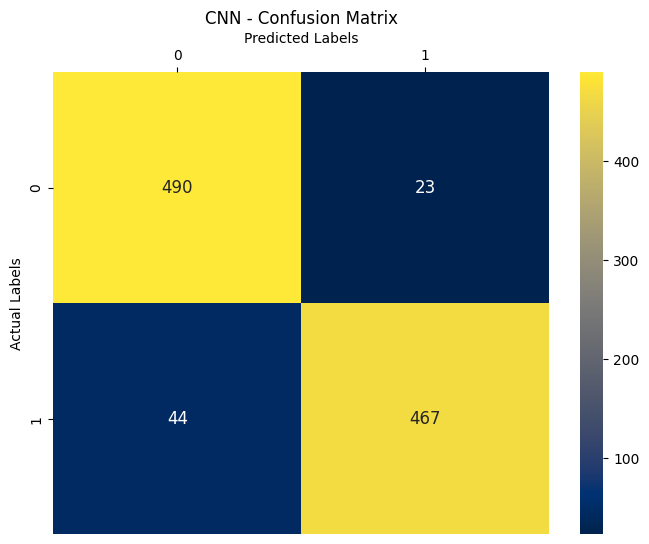

In [ ]:
# Generate the confusion matrix
CNN_conf_matrix = confusion_matrix(CNN_y_true_classes, CNN_y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(CNN_conf_matrix, annot=True, fmt='d', cmap='cividis',
            xticklabels=['0', '1'], yticklabels=['0', '1'], annot_kws={"size": 12})
plt.title('CNN - Confusion Matrix')
plt.ylabel('Actual Labels')
plt.xlabel('')

plt.gca().xaxis.tick_top()
plt.gca().xaxis.set_label_position('top')
plt.xlabel('Predicted Labels')

# Save the plot
plt.savefig('fig_08.png', format='png', dpi=300)
plt.show()

### ANN - Artificial Neural Networks



In [ ]:
# Function to Clear Keras Session
K.clear_session()
print("Keras session cleared.")

Keras session cleared.


In [ ]:
# Convert each image to a flattened array
ANN_X_train = np.array([img.flatten() for img in balanced_train_df['img_arr']])
ANN_X_val = np.array([img.flatten() for img in val_df['img_arr']])
ANN_X_test = np.array([img.flatten() for img in test_df['img_arr']])

In [ ]:
# Extract labels
ANN_y_train = balanced_train_df['binary_label'].values
ANN_y_val = val_df['binary_label'].values
ANN_y_test = test_df['binary_label'].values

In [ ]:
# Ensure that the data and labels for training, validation, and test sets have matching lengths
assert len(ANN_X_train) == len(ANN_y_train), "Training data and labels size mismatch!"
assert len(ANN_X_val) == len(ANN_y_val), "Validation data and labels size mismatch!"
assert len(ANN_X_test) == len(ANN_y_test), "Test data and labels size mismatch!"

In [ ]:
# Normalize features using StandardScaler
scaler = StandardScaler()
ANN_X_train_normalized = scaler.fit_transform(ANN_X_train)
ANN_X_val_normalized = scaler.transform(ANN_X_val)
ANN_X_test_normalized = scaler.transform(ANN_X_test)

# Print shapes to verify
print(f"Train features shape: {ANN_X_train_normalized.shape}")
print(f"Validation features shape: {ANN_X_val_normalized.shape}")
print(f"Test features shape: {ANN_X_test_normalized.shape}")

Train features shape: (3080, 16384)
Validation features shape: (1024, 16384)
Test features shape: (1024, 16384)


In [ ]:
# Build the ANN Model
ANN_model = Sequential([
    Input(shape=(ANN_X_train_normalized.shape[1],)),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

In [ ]:
# Summary of the model
ANN_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 128)                 │       2,097,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,105,601 (8.03 MB)

 Trainable params: 2,105,601 (8.03 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Compile the Model
ANN_model.compile(optimizer=Adam(learning_rate=0.001),loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# Stop training if val_loss doesn't improve for 5 epochs
ANN_early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [ ]:
# Build the ANN Model
ANN_history = ANN_model.fit(
    ANN_X_train_normalized, ANN_y_train,
    validation_data=(ANN_X_val_normalized, ANN_y_val),
    epochs=60,
    batch_size=64,
    callbacks=[ANN_early_stopping],
    verbose=1
)

Epoch 1/60
49/49 ━━━━━━━━━━━━━━━━━━━━ 6s 68ms/step - accuracy: 0.6344 - loss: 1.3310 - val_accuracy: 0.7666 - val_loss: 0.6661
Epoch 2/60
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7740 - loss: 0.7863 - val_accuracy: 0.8057 - val_loss: 0.4248
Epoch 3/60
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8421 - loss: 0.4881 - val_accuracy: 0.8545 - val_loss: 0.3450
Epoch 4/60
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8781 - loss: 0.3414 - val_accuracy: 0.8672 - val_loss: 0.3254
Epoch 5/60
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9127 - loss: 0.2505 - val_accuracy: 0.8828 - val_loss: 0.2913
Epoch 6/60
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9321 - loss: 0.1615 - val_accuracy: 0.8984 - val_loss: 0.2712
Epoch 7/60
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9561 - loss: 0.1188 - val_accuracy: 0.9111 - val_loss: 0.2452
Epoch 8/60
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9479 - loss: 0.1470 - val_accuracy: 0.9199 - val_loss

In [ ]:
# Evaluate the model on the test set
ANN_evaluation = ANN_model.evaluate(ANN_X_test, ANN_y_test, verbose=1)

# Extract loss and accuracy
ANN_test_loss, ANN_test_accuracy = ANN_evaluation[0], ANN_evaluation[1]

# Display the results in a formatted output
print(f"ANN Evaluation Results:")
print(f" - Test Loss: {ANN_test_loss:.4f}")
print(f" - Test Accuracy: {ANN_test_accuracy:.4f}")

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5150 - loss: 892.0240   
ANN Evaluation Results:
 - Test Loss: 924.1209
 - Test Accuracy: 0.5010


In [ ]:
# Extract training and validation metrics for ANN
ANN_train_loss = ANN_history.history['loss']
ANN_val_loss = ANN_history.history['val_loss']
ANN_train_accuracy = ANN_history.history['accuracy']
ANN_val_accuracy = ANN_history.history['val_accuracy']

# Display final train and validation metrics for ANN
print(f"ANN Training Loss: {ANN_train_loss[-1]:.4f}")
print(f"ANN Validation Loss: {ANN_val_loss[-1]:.4f}")
print(f"ANN Training Accuracy: {ANN_train_accuracy[-1]:.4f}")
print(f"ANN Validation Accuracy: {ANN_val_accuracy[-1]:.4f}")

ANN Training Loss: 0.0386
ANN Validation Loss: 0.3061
ANN Training Accuracy: 0.9828
ANN Validation Accuracy: 0.9170


In [ ]:
# Save the ANN model
ANN_model.save('ann_alzheimer_classifier.keras')

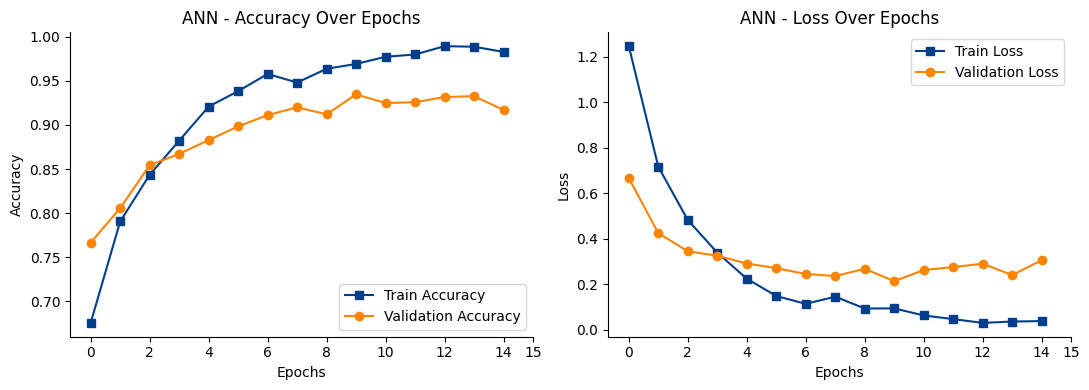

In [ ]:
# Create combined of ANN accuracy and loss
fig, axs = plt.subplots(1, 2, figsize=(11, 4))

# Plot accuracy
axs[0].plot(ANN_train_accuracy, label='Train Accuracy', marker='s', color='#023e8a')
axs[0].plot(ANN_val_accuracy, label='Validation Accuracy', marker='o', color='#fb8500')
axs[0].set_title('ANN - Accuracy Over Epochs')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Accuracy')
axs[0].legend()
axs[0].spines['top'].set_visible(False)
axs[0].spines['right'].set_visible(False)
epochs = range(1, len(ANN_history.history['loss']) + 1)
multiples_of_2 = [x for x in epochs if x % 2 == 0]
if 0 not in multiples_of_2:
    multiples_of_2 = [0] + multiples_of_2
if epochs[-1] not in multiples_of_2:
    multiples_of_2.append(epochs[-1])
axs[0].set_xticks(multiples_of_2)

# Plot loss
axs[1].plot(ANN_train_loss, label='Train Loss', marker='s', color='#023e8a')
axs[1].plot(ANN_val_loss, label='Validation Loss', marker='o', color='#fb8500')
axs[1].set_title('ANN - Loss Over Epochs')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Loss')
axs[1].legend()
axs[1].spines['top'].set_visible(False)
axs[1].spines['right'].set_visible(False)
axs[1].set_xticks(multiples_of_2)

plt.tight_layout()
plt.savefig('fig_09.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# Predict on the test dataset
ANN_y_pred = (ANN_model.predict(ANN_X_test_normalized) > 0.5).astype(int)

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [ ]:
# Generate ANN Classification Report
print("Classification Report for ANN:")
ANN_classification_report = classification_report(ANN_y_test,ANN_y_pred, target_names=['0 - No Alzheimer', '1 - Early Alzheimer'])
print(ANN_classification_report)

Classification Report for ANN:
                     precision    recall  f1-score   support

   0 - No Alzheimer       0.90      0.90      0.90       513
1 - Early Alzheimer       0.90      0.90      0.90       511

           accuracy                           0.90      1024
          macro avg       0.90      0.90      0.90      1024
       weighted avg       0.90      0.90      0.90      1024



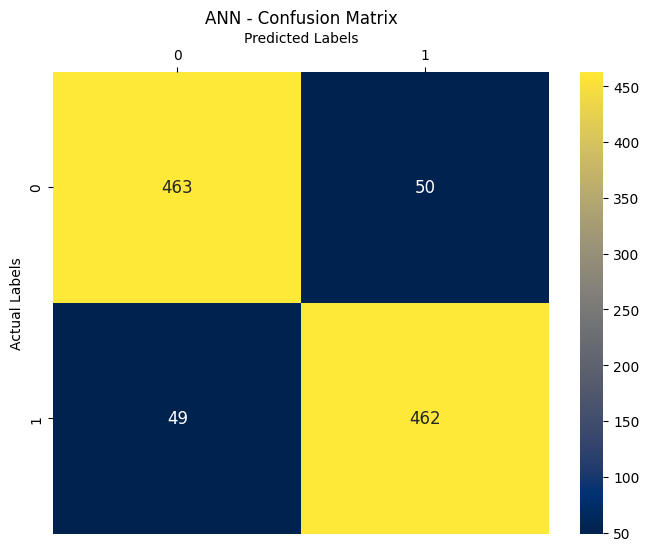

In [ ]:
# Generate Confusion Matrix
ANN_conf_matrix = confusion_matrix(ANN_y_test, ANN_y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(ANN_conf_matrix, annot=True, fmt='d', cmap='cividis',
            xticklabels=['0', '1'], yticklabels=['0', '1'], annot_kws={"size": 12})
plt.title('ANN - Confusion Matrix')
plt.ylabel('Actual Labels')
plt.xlabel('')

plt.gca().xaxis.tick_top()
plt.gca().xaxis.set_label_position('top')
plt.xlabel('Predicted Labels')

# Save the plot
plt.savefig('fig_10.png', format='png', dpi=300)
plt.show()

### ResNet50 - Residual Network

In [ ]:
# Function to Clear Keras Session
K.clear_session()
print("Keras session cleared.")

Keras session cleared.


In [ ]:
# ResNet Preprocessing
input_shape = (128, 128, 3)  # ResNet requires 3 channels, so we can stack grayscale images
RN_X_train = np.stack([np.stack((img,)*3, axis=-1) for img in balanced_train_df['img_arr'].values]).reshape(-1, 128, 128, 3) / 255.0
RN_y_train = to_categorical(balanced_train_df['binary_label'].values, num_classes=2)

RN_X_val = np.stack([np.stack((img,)*3, axis=-1) for img in val_df['img_arr'].values]).reshape(-1, 128, 128, 3) / 255.0
RN_y_val = to_categorical(val_df['binary_label'].values, num_classes=2)

RN_X_test = np.stack([np.stack((img,)*3, axis=-1) for img in test_df['img_arr'].values]).reshape(-1, 128, 128, 3) / 255.0
RN_y_test = to_categorical(test_df['binary_label'].values, num_classes=2)

In [ ]:
# Ensure that the data and labels for training, validation, and test sets have matching lengths
assert len(RN_X_train) == len(RN_y_train), "Training data and labels size mismatch!"
assert len(RN_X_val) == len(RN_y_val), "Validation data and labels size mismatch!"
assert len(RN_X_test) == len(RN_y_test), "Test data and labels size mismatch!"

In [ ]:
# Load the ResNet model with pretrained weights
RN_base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Add custom layers for our dataset
x = RN_base_model.output
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(2, activation='softmax')(x)  # Binary classification

In [ ]:
# Define the final model
RN_model = Model(inputs=RN_base_model.input, outputs=predictions)

In [ ]:
# Freeze the layers in the base model
for layer in RN_base_model.layers:
    layer.trainable = False

In [ ]:
# Compile the model
RN_model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Display the model summary
RN_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 128, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 134, 134, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 64, 64, 64)     │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 64, 64, 64)     │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 64, 64, 64)     │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 66, 66, 64)     │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 32, 32, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 32, 32, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 32, 32, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 32, 32, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 32, 32, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 32, 32, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 32, 32, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 32, 32, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 32, 32, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 27,782,402 (105.98 MB)

 Trainable params: 4,194,690 (16.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
# Stop training if val_loss doesn't improve for 5 epochs
RN_early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [ ]:
# Train the ResNet model
RN_history = RN_model.fit(
    RN_X_train, RN_y_train,
    validation_data=(RN_X_val, RN_y_val),
    epochs=60,
    batch_size=64,
    callbacks=[RN_early_stopping],
    verbose=1
)

Epoch 1/60
49/49 ━━━━━━━━━━━━━━━━━━━━ 27s 304ms/step - accuracy: 0.5293 - loss: 0.7502 - val_accuracy: 0.6611 - val_loss: 0.6521
Epoch 2/60
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 82ms/step - accuracy: 0.6130 - loss: 0.6634 - val_accuracy: 0.6621 - val_loss: 0.6376
Epoch 3/60
49/49 ━━━━━━━━━━━━━━━━━━━━ 5s 86ms/step - accuracy: 0.6461 - loss: 0.6488 - val_accuracy: 0.6230 - val_loss: 0.6441
Epoch 4/60
49/49 ━━━━━━━━━━━━━━━━━━━━ 5s 90ms/step - accuracy: 0.6253 - loss: 0.6446 - val_accuracy: 0.6562 - val_loss: 0.6327
Epoch 5/60
49/49 ━━━━━━━━━━━━━━━━━━━━ 5s 82ms/step - accuracy: 0.6371 - loss: 0.6390 - val_accuracy: 0.6826 - val_loss: 0.6285
Epoch 6/60
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 88ms/step - accuracy: 0.6564 - loss: 0.6298 - val_accuracy: 0.6436 - val_loss: 0.6386
Epoch 7/60
49/49 ━━━━━━━━━━━━━━━━━━━━ 5s 81ms/step - accuracy: 0.6403 - loss: 0.6401 - val_accuracy: 0.6514 - val_loss: 0.6172
Epoch 8/60
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 89ms/step - accuracy: 0.6683 - loss: 0.6224 - val_accuracy: 0.6895 -

In [ ]:
# Evaluate the model
RN_evaluation = RN_model.evaluate(RN_X_test, RN_y_test, verbose=1)
RN_test_loss, RN_test_accuracy = RN_evaluation[0], RN_evaluation[1]

# Print evaluation results
print(f"ResNet Evaluation Results:")
print(f" - Test Loss: {RN_test_loss:.4f}")
print(f" - Test Accuracy: {RN_test_accuracy:.4f}")

32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - accuracy: 0.7463 - loss: 0.5343
ResNet Evaluation Results:
 - Test Loss: 0.5527
 - Test Accuracy: 0.7275


In [ ]:
# Extract training and validation metrics for ResNet
RN_train_loss = RN_history.history['loss']
RN_val_loss = RN_history.history['val_loss']
RN_train_accuracy = RN_history.history['accuracy']
RN_val_accuracy = RN_history.history['val_accuracy']

# Display final train and validation metrics for ResNet
print(f"ResNet Training Loss: {RN_train_loss[-1]:.4f}")
print(f"ResNet Validation Loss: {RN_val_loss[-1]:.4f}")
print(f"ResNet Training Accuracy: {RN_train_accuracy[-1]:.4f}")
print(f"ResNet Validation Accuracy: {RN_val_accuracy[-1]:.4f}")

ResNet Training Loss: 0.5363
ResNet Validation Loss: 0.5357
ResNet Training Accuracy: 0.7357
ResNet Validation Accuracy: 0.7412


In [ ]:
# Save the model
RN_model.save('resnet_alzheimer_classifier.keras')

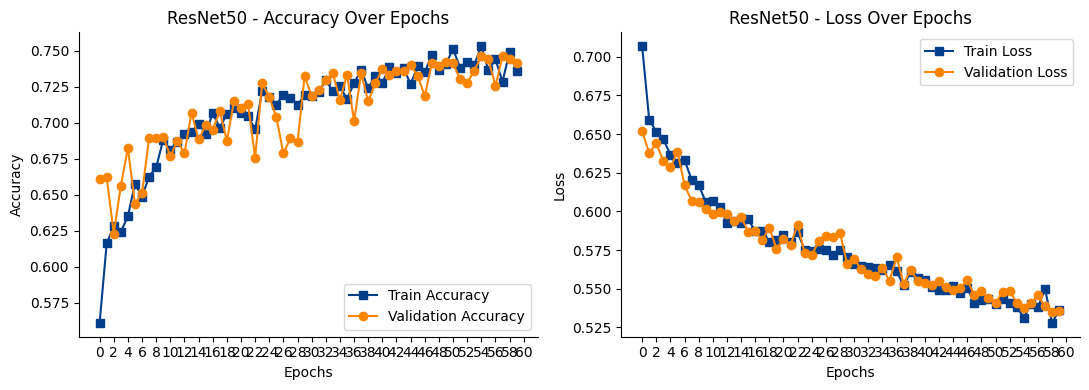

In [ ]:
# Create combined ResNet accuracy and loss plots
fig, axs = plt.subplots(1, 2, figsize=(11, 4))

# Plot accuracy
axs[0].plot(RN_history.history['accuracy'], label='Train Accuracy', marker='s', color='#023e8a')
axs[0].plot(RN_history.history['val_accuracy'], label='Validation Accuracy', marker='o', color='#fb8500')
axs[0].set_title('ResNet50 - Accuracy Over Epochs')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Accuracy')
axs[0].legend()
axs[0].spines['top'].set_visible(False)
axs[0].spines['right'].set_visible(False)

# Ensure x-ticks are multiples of 2
epochs = range(1, len(RN_history.history['loss']) + 1)
multiples_of_2 = [x for x in epochs if x % 2 == 0]
if 0 not in multiples_of_2:
    multiples_of_2 = [0] + multiples_of_2
if epochs[-1] not in multiples_of_2:
    multiples_of_2.append(epochs[-1])
axs[0].set_xticks(multiples_of_2)

# Plot loss
axs[1].plot(RN_history.history['loss'], label='Train Loss', marker='s', color='#023e8a')
axs[1].plot(RN_history.history['val_loss'], label='Validation Loss', marker='o', color='#fb8500')
axs[1].set_title('ResNet50 - Loss Over Epochs')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Loss')
axs[1].legend()
axs[1].spines['top'].set_visible(False)
axs[1].spines['right'].set_visible(False)
axs[1].set_xticks(multiples_of_2)

# Adjust layout and save the figure
plt.tight_layout()
plt.savefig('fig_11.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# Predict classes for the test set
RN_y_pred = RN_model.predict(RN_X_test, verbose=1)
RN_y_pred_classes = np.argmax(RN_y_pred, axis=1)  # Predicted class indices
RN_y_true_classes = np.argmax(RN_y_test, axis=1)  # True class indices

32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step


In [ ]:
# Generate ResNet Classification Report
RN_classification_report = classification_report(
    RN_y_true_classes, RN_y_pred_classes, target_names=['0 - No Alzheimer', '1 - Early Alzheimer']
)
print("Classification Report for ResNet50:")
print(RN_classification_report)

Classification Report for ResNet50:
                     precision    recall  f1-score   support

   0 - No Alzheimer       0.74      0.70      0.72       513
1 - Early Alzheimer       0.71      0.76      0.74       511

           accuracy                           0.73      1024
          macro avg       0.73      0.73      0.73      1024
       weighted avg       0.73      0.73      0.73      1024



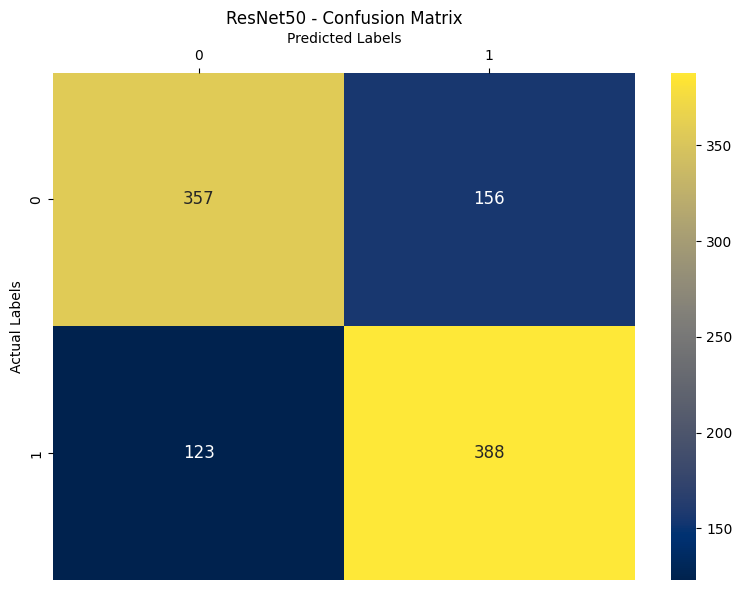

In [ ]:
# Generate Confusion Matrix
RN_conf_matrix = confusion_matrix(RN_y_true_classes, RN_y_pred_classes)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(RN_conf_matrix, annot=True, fmt='d', cmap='cividis',
            xticklabels=['0', '1'],
            yticklabels=['0', '1'],
            annot_kws={"size": 12})

plt.title('ResNet50 - Confusion Matrix')
plt.ylabel('Actual Labels')
plt.xlabel('')

# Adjust label positions
plt.gca().xaxis.tick_top()
plt.gca().xaxis.set_label_position('top')
plt.xlabel('Predicted Labels')

# Save the plot
plt.tight_layout()
plt.savefig('fig_12.png', format='png', dpi=300)
plt.show()

### VGGNet16 - Visual Geometry Group Network

In [ ]:
# Function to Clear Keras Session
K.clear_session()
print("Keras session cleared.")

Keras session cleared.


In [ ]:
# Preprocessing for VGGNet
input_shape = (128, 128, 3)  # VGGNet requires 3 channels, so we can stack grayscale images
VGG_X_train = np.stack([np.stack((img,) * 3, axis=-1) for img in balanced_train_df['img_arr'].values]).reshape(-1, 128, 128, 3) / 255.0
VGG_y_train = to_categorical(balanced_train_df['binary_label'].values, num_classes=2)

VGG_X_val = np.stack([np.stack((img,) * 3, axis=-1) for img in val_df['img_arr'].values]).reshape(-1, 128, 128, 3) / 255.0
VGG_y_val = to_categorical(val_df['binary_label'].values, num_classes=2)

VGG_X_test = np.stack([np.stack((img,) * 3, axis=-1) for img in test_df['img_arr'].values]).reshape(-1, 128, 128, 3) / 255.0
VGG_y_test = to_categorical(test_df['binary_label'].values, num_classes=2)

In [ ]:
# Ensure that the data and labels for training, validation, and test sets have matching lengths
assert len(VGG_X_train) == len(VGG_y_train), "Training data and labels size mismatch!"
assert len(VGG_X_val) == len(VGG_y_val), "Validation data and labels size mismatch!"
assert len(VGG_X_test) == len(VGG_y_test), "Test data and labels size mismatch!"

In [ ]:
# Load the VGG16 model with pretrained weights
VGG_base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
# Add custom layers for our dataset
x = VGG_base_model.output
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(2, activation='softmax')(x)  # Binary classification

In [ ]:
# Define the final model
VGG_model = Model(inputs=VGG_base_model.input, outputs=predictions)

In [ ]:
# Freeze the layers in the base model
for layer in VGG_base_model.layers:
    layer.trainable = False

In [ ]:
# Compile the model
VGG_model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Display the model summary
VGG_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 128, 128, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 128, 128, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 64, 64, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 32, 32, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 32, 32, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 32, 32, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 16, 16, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 8, 8, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 4, 4, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       1,048,704 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 15,763,650 (60.13 MB)

 Trainable params: 1,048,962 (4.00 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
# Stop training if val_loss doesn't improve for 5 epochs
VGG_early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [ ]:
# Train the VGGNet model
VGG_history = VGG_model.fit(
    VGG_X_train, VGG_y_train,
    validation_data=(VGG_X_val, VGG_y_val),
    epochs=60,
    batch_size=64,
    callbacks=[VGG_early_stopping],
    verbose=1
)

Epoch 1/60
49/49 ━━━━━━━━━━━━━━━━━━━━ 28s 253ms/step - accuracy: 0.5471 - loss: 0.7873 - val_accuracy: 0.5312 - val_loss: 0.6820
Epoch 2/60
49/49 ━━━━━━━━━━━━━━━━━━━━ 21s 137ms/step - accuracy: 0.5994 - loss: 0.6590 - val_accuracy: 0.7109 - val_loss: 0.5979
Epoch 3/60
49/49 ━━━━━━━━━━━━━━━━━━━━ 9s 113ms/step - accuracy: 0.6868 - loss: 0.6045 - val_accuracy: 0.7354 - val_loss: 0.5693
Epoch 4/60
49/49 ━━━━━━━━━━━━━━━━━━━━ 12s 140ms/step - accuracy: 0.7000 - loss: 0.5830 - val_accuracy: 0.7510 - val_loss: 0.5564
Epoch 5/60
49/49 ━━━━━━━━━━━━━━━━━━━━ 6s 118ms/step - accuracy: 0.7387 - loss: 0.5533 - val_accuracy: 0.7432 - val_loss: 0.5465
Epoch 6/60
49/49 ━━━━━━━━━━━━━━━━━━━━ 6s 117ms/step - accuracy: 0.7172 - loss: 0.5552 - val_accuracy: 0.7646 - val_loss: 0.5323
Epoch 7/60
49/49 ━━━━━━━━━━━━━━━━━━━━ 10s 113ms/step - accuracy: 0.7187 - loss: 0.5535 - val_accuracy: 0.7090 - val_loss: 0.5411
Epoch 8/60
49/49 ━━━━━━━━━━━━━━━━━━━━ 10s 112ms/step - accuracy: 0.7273 - loss: 0.5414 - val_accurac

In [ ]:
# Evaluate the model
VGG_evaluation = VGG_model.evaluate(VGG_X_test, VGG_y_test, verbose=1)
VGG_test_loss, VGG_test_accuracy = VGG_evaluation[0], VGG_evaluation[1]

# Print evaluation results
print(f"VGGNet16 Evaluation Results:")
print(f" - Test Loss: {VGG_test_loss:.4f}")
print(f" - Test Accuracy: {VGG_test_accuracy:.4f}")

32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.8414 - loss: 0.3500
VGGNet16 Evaluation Results:
 - Test Loss: 0.3798
 - Test Accuracy: 0.8291


In [ ]:
# Extract training and validation metrics for VGGNet
VGG_train_loss = VGG_history.history['loss']
VGG_val_loss = VGG_history.history['val_loss']
VGG_train_accuracy = VGG_history.history['accuracy']
VGG_val_accuracy = VGG_history.history['val_accuracy']

# Display final train and validation metrics for VGGNet
print(f"VGGNet16 Training Loss: {VGG_train_loss[-1]:.4f}")
print(f"VGGNet16 Validation Loss: {VGG_val_loss[-1]:.4f}")
print(f"VGGNet16 Training Accuracy: {VGG_train_accuracy[-1]:.4f}")
print(f"VGGNet16 Validation Accuracy: {VGG_val_accuracy[-1]:.4f}")

VGGNet16 Training Loss: 0.2083
VGGNet16 Validation Loss: 0.4094
VGGNet16 Training Accuracy: 0.9253
VGGNet16 Validation Accuracy: 0.8076


In [ ]:
# Save the model
VGG_model.save('vggnet_alzheimer_classifier.keras')

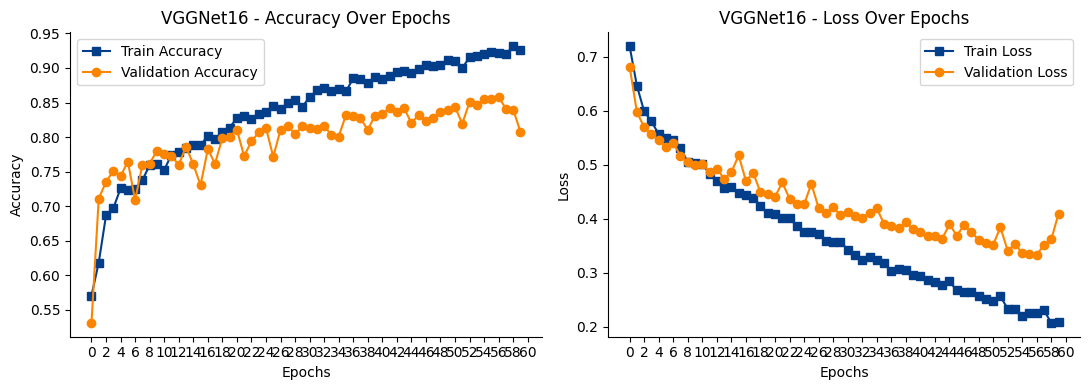

In [ ]:
# Create combined VGGNet accuracy and loss plots
fig, axs = plt.subplots(1, 2, figsize=(11, 4))

# Plot accuracy
axs[0].plot(VGG_history.history['accuracy'], label='Train Accuracy', marker='s', color='#023e8a')
axs[0].plot(VGG_history.history['val_accuracy'], label='Validation Accuracy', marker='o', color='#fb8500')
axs[0].set_title('VGGNet16 - Accuracy Over Epochs')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Accuracy')
axs[0].legend()
axs[0].spines['top'].set_visible(False)
axs[0].spines['right'].set_visible(False)

# Ensure x-ticks are multiples of 2
epochs = range(1, len(VGG_history.history['loss']) + 1)
multiples_of_2 = [x for x in epochs if x % 2 == 0]
if 0 not in multiples_of_2:
    multiples_of_2 = [0] + multiples_of_2
if epochs[-1] not in multiples_of_2:
    multiples_of_2.append(epochs[-1])
axs[0].set_xticks(multiples_of_2)

# Plot loss
axs[1].plot(VGG_history.history['loss'], label='Train Loss', marker='s', color='#023e8a')
axs[1].plot(VGG_history.history['val_loss'], label='Validation Loss', marker='o', color='#fb8500')
axs[1].set_title('VGGNet16 - Loss Over Epochs')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Loss')
axs[1].legend()
axs[1].spines['top'].set_visible(False)
axs[1].spines['right'].set_visible(False)
axs[1].set_xticks(multiples_of_2)

# Adjust layout and save the figure
plt.tight_layout()
plt.savefig('fig_13.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# Predict on the test set
VGG_y_pred_probs = VGG_model.predict(VGG_X_test)  # Get probabilities
VGG_y_pred = np.argmax(VGG_y_pred_probs, axis=1)  # Convert to class labels
VGG_y_true = np.argmax(VGG_y_test, axis=1)  # True class labels

32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step


In [ ]:
# Generate classification report
VGG_report = classification_report(VGG_y_true, VGG_y_pred, target_names=['0 - No Alzheimer', '1 - Early Alzheimer'])

# Print the classification report
print("Classification Report for VGGNet16:")
print(VGG_report)

Classification Report for VGGNet16:
                     precision    recall  f1-score   support

   0 - No Alzheimer       0.81      0.86      0.83       513
1 - Early Alzheimer       0.85      0.80      0.82       511

           accuracy                           0.83      1024
          macro avg       0.83      0.83      0.83      1024
       weighted avg       0.83      0.83      0.83      1024



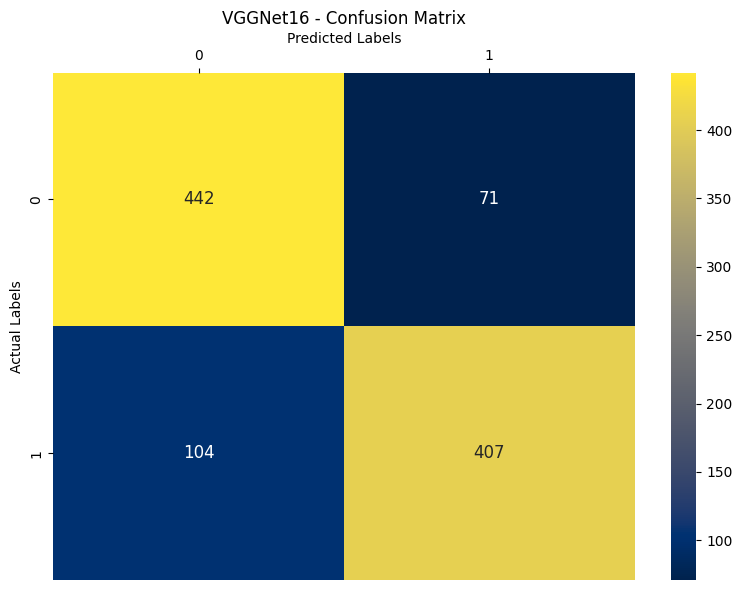

In [ ]:
# Generate Confusion Matrix
VGG_conf_matrix = confusion_matrix(VGG_y_true, VGG_y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(VGG_conf_matrix, annot=True, fmt='d', cmap='cividis',
            xticklabels=['0', '1'],
            yticklabels=['0', '1'],
            annot_kws={"size": 12})

plt.title('VGGNet16 - Confusion Matrix')
plt.ylabel('Actual Labels')
plt.xlabel('')

# Adjust label positions
plt.gca().xaxis.tick_top()
plt.gca().xaxis.set_label_position('top')
plt.xlabel('Predicted Labels')

# Save the plot
plt.tight_layout()
plt.savefig('fig_14.png', format='png', dpi=300)
plt.show()

### ViT - Vision Transformers

In [ ]:
# Function to Clear Keras Session
K.clear_session()
print("Keras session cleared.")

Keras session cleared.


In [ ]:
# Convert 'img_arr' column to a NumPy array
ViT_train_images = np.stack(train_df['img_arr'].values)
ViT_val_images = np.stack(val_df['img_arr'].values)
ViT_test_images = np.stack(test_df['img_arr'].values)

# Ensure labels are NumPy arrays
ViT_train_labels = train_df['binary_label'].values
ViT_val_labels = val_df['binary_label'].values
ViT_test_labels = test_df['binary_label'].values

In [ ]:
# Normalize the train, validation, and test image datasets by scaling pixel values to the range [0, 1].
ViT_train_images = ViT_train_images / 255.0
ViT_val_images = ViT_val_images / 255.0
ViT_test_images = ViT_test_images / 255.0

In [ ]:
# Print the shape and data type of the train, validation, and test image datasets for verification and debugging
print(f"Train images shape: {ViT_train_images.shape}, dtype: {ViT_train_images.dtype}")
print(f"Validation images shape: {ViT_val_images.shape}, dtype: {ViT_val_images.dtype}")
print(f"Test images shape: {ViT_test_images.shape}, dtype: {ViT_test_images.dtype}")

Train images shape: (3072, 128, 128), dtype: float64
Validation images shape: (1024, 128, 128), dtype: float64
Test images shape: (1024, 128, 128), dtype: float64


In [ ]:
# Define the Vision Transformer (ViT) Model
def create_vit_model(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)

    # Patch creation
    patch_size = 16  # Size of patches
    patches = layers.Conv2D(64, patch_size, patch_size, padding='valid')(inputs)
    patches = layers.Reshape((-1, patches.shape[-1]))(patches)

    # Transformer encoder
    for _ in range(8):  # Number of transformer blocks
        # Attention mechanism
        attention_output = layers.MultiHeadAttention(num_heads=8, key_dim=64)(patches, patches)
        x = layers.Add()([patches, attention_output])
        x = layers.LayerNormalization()(x)

        # Feed-forward network
        feed_forward_output = layers.Dense(128, activation='relu')(x)
        feed_forward_output = layers.Dense(64)(feed_forward_output)
        x = layers.Add()([x, feed_forward_output])
        patches = layers.LayerNormalization()(x)

    # Classification head
    x = layers.GlobalAveragePooling1D()(patches)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    return models.Model(inputs, outputs)

In [ ]:
# Define input shape and number of classes
input_shape = (128, 128, 1)
num_classes = 2

In [ ]:
# Create the model
ViT_model = create_vit_model(input_shape, num_classes)

In [ ]:
# Compile the model
ViT_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
# Display the model summary
ViT_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 128, 1)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 8, 8, 64)       │         16,448 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape (Reshape)         │ (None, 64, 64)         │              0 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention      │ (None, 64, 64)         │        132,672 │ reshape[0][0],         │
│ (MultiHeadAttention)      │                        │                │ reshape[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 64, 64)         │              0 │ reshape[0][0],         │
│                           │                        │                │ multi_head_attention[… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization       │ (None, 64, 64)         │            128 │ add[0][0]              │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 64, 128)        │          8,320 │ layer_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 64, 64)         │          8,256 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_1 (Add)               │ (None, 64, 64)         │              0 │ layer_normalization[0… │
│                           │                        │                │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_1     │ (None, 64, 64)         │            128 │ add_1[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_1    │ (None, 64, 64)         │        132,672 │ layer_normalization_1… │
│ (MultiHeadAttention)      │                        │                │ layer_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_2 (Add)               │ (None, 64, 64)         │              0 │ layer_normalization_1… │
│                           │                        │                │ multi_head_attention_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_2     │ (None, 64, 64)         │            128 │ add_2[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 64, 128)        │          8,320 │ layer_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 64, 64)         │          8,256 │ dense_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_3 (Add)          

 Total params: 1,212,610 (4.63 MB)

 Trainable params: 1,212,610 (4.63 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_vit_model.keras', save_best_only=True, monitor='val_loss')

In [ ]:
# Training the model
ViT_history = ViT_model.fit(
    ViT_train_images, ViT_train_labels,
    validation_data=(ViT_val_images, ViT_val_labels),
    epochs=60,
    batch_size=64,
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/60
48/48 ━━━━━━━━━━━━━━━━━━━━ 42s 136ms/step - accuracy: 0.5129 - loss: 0.7670 - val_accuracy: 0.4990 - val_loss: 0.6889
Epoch 2/60
48/48 ━━━━━━━━━━━━━━━━━━━━ 23s 47ms/step - accuracy: 0.5357 - loss: 0.6894 - val_accuracy: 0.4990 - val_loss: 0.7302
Epoch 3/60
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy: 0.5358 - loss: 0.6898 - val_accuracy: 0.5068 - val_loss: 0.6817
Epoch 4/60
48/48 ━━━━━━━━━━━━━━━━━━━━ 5s 59ms/step - accuracy: 0.5720 - loss: 0.6684 - val_accuracy: 0.7061 - val_loss: 0.6121
Epoch 5/60
48/48 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.6385 - loss: 0.6392 - val_accuracy: 0.5352 - val_loss: 0.7177
Epoch 6/60
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.6493 - loss: 0.6313 - val_accuracy: 0.7109 - val_loss: 0.5692
Epoch 7/60
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - accuracy: 0.6868 - loss: 0.5936 - val_accuracy: 0.7236 - val_loss: 0.5679
Epoch 8/60
48/48 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - accuracy: 0.6865 - loss: 0.5926 - val_accuracy: 0.7109 

In [ ]:
# Save the model
ViT_model.save('final_vit_model.keras')

In [ ]:
# Evaluate the Vision Transformer (ViT) model
ViT_evaluation = ViT_model.evaluate(ViT_test_images, ViT_test_labels, verbose=1)
ViT_test_loss, ViT_test_accuracy = ViT_evaluation[0], ViT_evaluation[1]

# Print evaluation results
print(f"Vision Transformer (ViT) Evaluation Results:")
print(f" - Test Loss: {ViT_test_loss:.4f}")
print(f" - Test Accuracy: {ViT_test_accuracy:.4f}")

32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.8704 - loss: 0.3367
Vision Transformer (ViT) Evaluation Results:
 - Test Loss: 0.3474
 - Test Accuracy: 0.8623


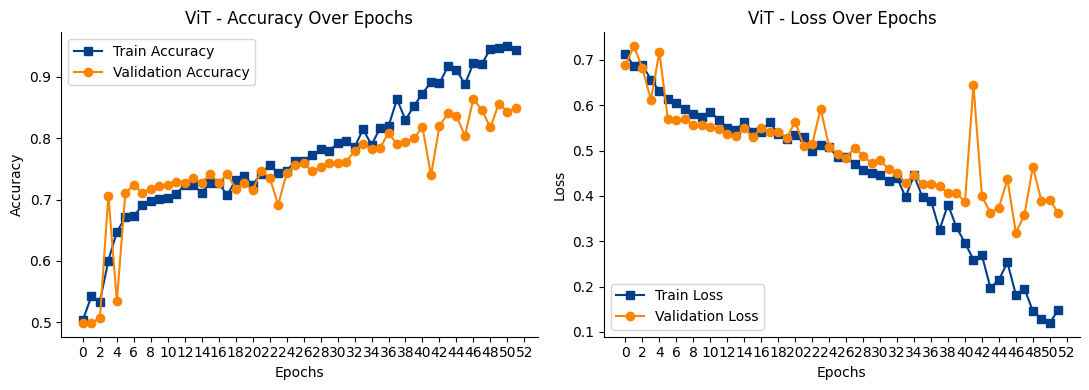

In [ ]:
# Create combined ViT accuracy and loss plots
fig, axs = plt.subplots(1, 2, figsize=(11, 4))

# Plot accuracy
axs[0].plot(ViT_history.history['accuracy'], label='Train Accuracy', marker='s', color='#023e8a')
axs[0].plot(ViT_history.history['val_accuracy'], label='Validation Accuracy', marker='o', color='#fb8500')
axs[0].set_title('ViT - Accuracy Over Epochs')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Accuracy')
axs[0].legend()
axs[0].spines['top'].set_visible(False)
axs[0].spines['right'].set_visible(False)

# Ensure x-ticks are multiples of 2
epochs = range(1, len(ViT_history.history['loss']) + 1)
multiples_of_2 = [x for x in epochs if x % 2 == 0]
if 0 not in multiples_of_2:
    multiples_of_2 = [0] + multiples_of_2
if epochs[-1] not in multiples_of_2:
    multiples_of_2.append(epochs[-1])
axs[0].set_xticks(multiples_of_2)

# Plot loss
axs[1].plot(ViT_history.history['loss'], label='Train Loss', marker='s', color='#023e8a')
axs[1].plot(ViT_history.history['val_loss'], label='Validation Loss', marker='o', color='#fb8500')
axs[1].set_title('ViT - Loss Over Epochs')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Loss')
axs[1].legend()
axs[1].spines['top'].set_visible(False)
axs[1].spines['right'].set_visible(False)
axs[1].set_xticks(multiples_of_2)

# Adjust layout and save the figure
plt.tight_layout()
plt.savefig('fig_15.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# Predict on the test set
ViT_y_pred = np.argmax(ViT_model.predict(ViT_test_images), axis=-1)

32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step


In [ ]:
# Generate classification report
ViT_report = classification_report(
    ViT_test_labels, ViT_y_pred, target_names=['0 - No Alzheimer', '1 - Early Alzheimer']
)

# Print the classification report
print("Classification Report for ViT:")
print(ViT_report)

Classification Report for ViT:
                     precision    recall  f1-score   support

   0 - No Alzheimer       0.89      0.83      0.86       513
1 - Early Alzheimer       0.84      0.89      0.87       511

           accuracy                           0.86      1024
          macro avg       0.86      0.86      0.86      1024
       weighted avg       0.86      0.86      0.86      1024



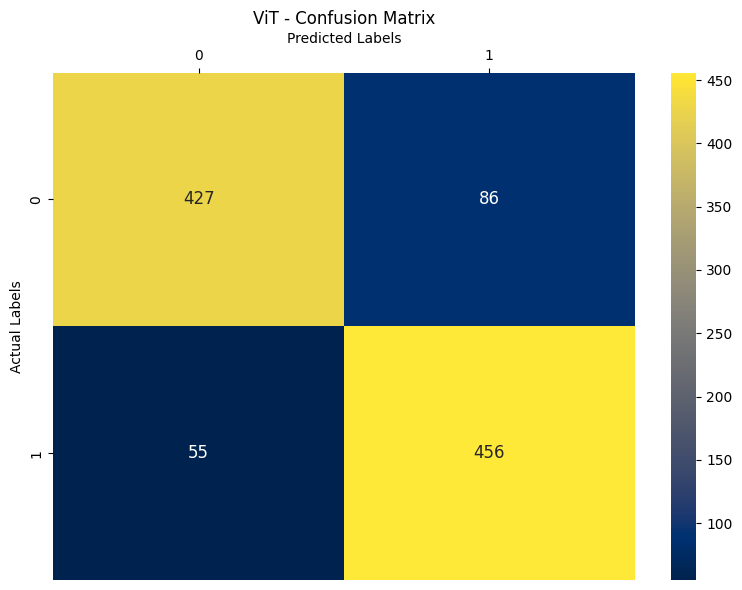

In [ ]:
# Generate Confusion Matrix
ViT_conf_matrix = confusion_matrix(ViT_test_labels, ViT_y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(ViT_conf_matrix, annot=True, fmt='d', cmap='cividis',
            xticklabels=['0', '1'],
            yticklabels=['0', '1'],
            annot_kws={"size": 12})

plt.title('ViT - Confusion Matrix')
plt.ylabel('Actual Labels')
plt.xlabel('')

# Adjust label positions
plt.gca().xaxis.tick_top()
plt.gca().xaxis.set_label_position('top')
plt.xlabel('Predicted Labels')

# Save the plot
plt.tight_layout()
plt.savefig('fig_16.png', format='png', dpi=300)
plt.show()

### Evaluation

In [ ]:
# Metrics for CNN
CNN_conf_matrix = confusion_matrix(CNN_y_true_classes, CNN_y_pred_classes)
CNN_metrics = {
    "Accuracy": round(accuracy_score(CNN_y_true_classes, CNN_y_pred_classes), 2),
    "Precision": round(precision_score(CNN_y_true_classes, CNN_y_pred_classes, average='weighted'), 2),
    "Recall": round(recall_score(CNN_y_true_classes, CNN_y_pred_classes, average='weighted'), 2),
    "F1 Score": round(f1_score(CNN_y_true_classes, CNN_y_pred_classes, average='weighted'), 2),
    "True Positive": CNN_conf_matrix[1, 1],
    "True Negative": CNN_conf_matrix[0, 0],
    "False Positive": CNN_conf_matrix[0, 1],
    "False Negative": CNN_conf_matrix[1, 0],
}

# Metrics for ANN
ANN_conf_matrix = confusion_matrix(ANN_y_test, ANN_y_pred)
ANN_metrics = {
    "Accuracy": round(accuracy_score(ANN_y_test, ANN_y_pred), 2),
    "Precision": round(precision_score(ANN_y_test, ANN_y_pred, average='weighted'), 2),
    "Recall": round(recall_score(ANN_y_test, ANN_y_pred, average='weighted'), 2),
    "F1 Score": round(f1_score(ANN_y_test, ANN_y_pred, average='weighted'), 2),
    "True Positive": ANN_conf_matrix[1, 1],
    "True Negative": ANN_conf_matrix[0, 0],
    "False Positive": ANN_conf_matrix[0, 1],
    "False Negative": ANN_conf_matrix[1, 0],
}

# Metrics for ResNet
RN_conf_matrix = confusion_matrix(RN_y_true_classes, RN_y_pred_classes)
RN_metrics = {
    "Accuracy": round(accuracy_score(RN_y_true_classes, RN_y_pred_classes), 2),
    "Precision": round(precision_score(RN_y_true_classes, RN_y_pred_classes, average='weighted'), 2),
    "Recall": round(recall_score(RN_y_true_classes, RN_y_pred_classes, average='weighted'), 2),
    "F1 Score": round(f1_score(RN_y_true_classes, RN_y_pred_classes, average='weighted'), 2),
    "True Positive": RN_conf_matrix[1, 1],
    "True Negative": RN_conf_matrix[0, 0],
    "False Positive": RN_conf_matrix[0, 1],
    "False Negative": RN_conf_matrix[1, 0],
}

# Metrics for VGGNet
VGG_conf_matrix = confusion_matrix(VGG_y_true, VGG_y_pred)
VGG_metrics = {
    "Accuracy": round(accuracy_score(VGG_y_true, VGG_y_pred), 2),
    "Precision": round(precision_score(VGG_y_true, VGG_y_pred, average='weighted'), 2),
    "Recall": round(recall_score(VGG_y_true, VGG_y_pred, average='weighted'), 2),
    "F1 Score": round(f1_score(VGG_y_true, VGG_y_pred, average='weighted'), 2),
    "True Positive": VGG_conf_matrix[1, 1],
    "True Negative": VGG_conf_matrix[0, 0],
    "False Positive": VGG_conf_matrix[0, 1],
    "False Negative": VGG_conf_matrix[1, 0],
}

# Metrics for ViT
ViT_conf_matrix = confusion_matrix(ViT_test_labels, ViT_y_pred)
ViT_metrics = {
    "Accuracy": round(accuracy_score(ViT_test_labels, ViT_y_pred), 2),
    "Precision": round(precision_score(ViT_test_labels, ViT_y_pred, average='weighted'), 2),
    "Recall": round(recall_score(ViT_test_labels, ViT_y_pred, average='weighted'), 2),
    "F1 Score": round(f1_score(ViT_test_labels, ViT_y_pred, average='weighted'), 2),
    "True Positive": ViT_conf_matrix[1, 1],
    "True Negative": ViT_conf_matrix[0, 0],
    "False Positive": ViT_conf_matrix[0, 1],
    "False Negative": ViT_conf_matrix[1, 0],
}

# Create and transpose the comparison table
comparison_table = pd.DataFrame(
    [CNN_metrics, ANN_metrics, RN_metrics, VGG_metrics, ViT_metrics],
    index=['CNN', 'ANN', 'ResNet50', 'VGGNet', 'ViT']
).T

# Explicitly format rows
def format_output(row):
    if row.name in ["True Positive", "True Negative", "False Positive", "False Negative"]:
        return row.astype(int)
    else:
        return row.apply(lambda x: f"{x:.2f}")

formatted_table = comparison_table.apply(format_output, axis=1)

# Display the table with proper formatting
print(formatted_table.to_string())

                 CNN   ANN ResNet50 VGGNet   ViT
Accuracy        0.93  0.90     0.73   0.83  0.86
Precision       0.94  0.90     0.73   0.83  0.86
Recall          0.93  0.90     0.73   0.83  0.86
F1 Score        0.93  0.90     0.73   0.83  0.86
True Positive    467   462      388    407   456
True Negative    490   463      357    442   427
False Positive    23    50      156     71    86
False Negative    44    49      123    104    55


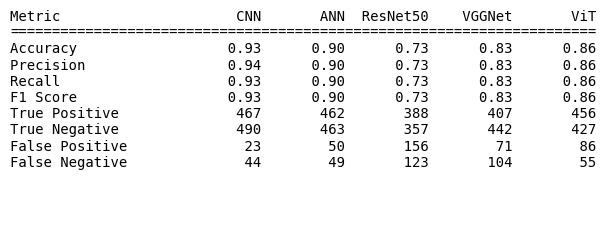

In [ ]:
# Convert the table to a formatted string
summary_str = StringIO()
summary_str.write(f"{'Metric':<20}{'CNN':>10}{'ANN':>10}{'ResNet50':>10}{'VGGNet':>10}{'ViT':>10}\n")
summary_str.write("=" * 70 + "\n")

for row in comparison_table.itertuples():
    metric = row.Index
    cnn_value = row.CNN
    ann_value = row.ANN
    resnet_value = row.ResNet50
    vgg_value = row.VGGNet
    vit_value = row.ViT

    # Format values based on metric type
    if metric in ["True Positive", "True Negative", "False Positive", "False Negative"]:
        cnn_value = f"{int(cnn_value):>10}"
        ann_value = f"{int(ann_value):>10}"
        resnet_value = f"{int(resnet_value):>10}"
        vgg_value = f"{int(vgg_value):>10}"
        vit_value = f"{int(vit_value):>10}"
    else:
        cnn_value = f"{cnn_value:>10.2f}"
        ann_value = f"{ann_value:>10.2f}"
        resnet_value = f"{resnet_value:>10.2f}"
        vgg_value = f"{vgg_value:>10.2f}"
        vit_value = f"{vit_value:>10.2f}"

    # Write formatted row
    summary_str.write(f"{metric:<20}{cnn_value}{ann_value}{resnet_value}{vgg_value}{vit_value}\n")

# Retrieve formatted string
summary_str = summary_str.getvalue()

# Plot the string as a figure
plt.figure(figsize=(6, 2.5))
plt.text(0, 1, summary_str, fontsize=10, family="monospace", va="top")
plt.axis("off")
plt.tight_layout()

# Save the figure
plt.savefig("fig_17.png", dpi=300, bbox_inches="tight")
plt.show()

In [ ]:
# Create heatmaps based on per-class metrics and overall averages
CNN_metrics_classes = {
    "Precision": precision_score(CNN_y_true_classes, CNN_y_pred_classes, average=None),
    "Recall": recall_score(CNN_y_true_classes, CNN_y_pred_classes, average=None),
    "F1 Score": f1_score(CNN_y_true_classes, CNN_y_pred_classes, average=None)
}
CNN_df = pd.DataFrame(CNN_metrics_classes, index=["Class 0", "Class 1"])
CNN_df.loc["Overall"] = [
    CNN_metrics["Precision"],
    CNN_metrics["Recall"],
    CNN_metrics["F1 Score"]
]

ANN_metrics_classes = {
    "Precision": precision_score(ANN_y_test, ANN_y_pred, average=None),
    "Recall": recall_score(ANN_y_test, ANN_y_pred, average=None),
    "F1 Score": f1_score(ANN_y_test, ANN_y_pred, average=None)
}
ANN_df = pd.DataFrame(ANN_metrics_classes, index=["Class 0", "Class 1"])
ANN_df.loc["Overall"] = [
    ANN_metrics["Precision"],
    ANN_metrics["Recall"],
    ANN_metrics["F1 Score"]
]

# Metrics for ResNet
RN_metrics_classes = {
    "Precision": precision_score(RN_y_true_classes, RN_y_pred_classes, average=None),
    "Recall": recall_score(RN_y_true_classes, RN_y_pred_classes, average=None),
    "F1 Score": f1_score(RN_y_true_classes, RN_y_pred_classes, average=None)
}
RN_df = pd.DataFrame(RN_metrics_classes, index=["Class 0", "Class 1"])
RN_df.loc["Overall"] = [
    RN_metrics["Precision"],
    RN_metrics["Recall"],
    RN_metrics["F1 Score"]
]

# Metrics for VGGNet
VGG_metrics_classes = {
    "Precision": precision_score(VGG_y_true, VGG_y_pred, average=None),
    "Recall": recall_score(VGG_y_true, VGG_y_pred, average=None),
    "F1 Score": f1_score(VGG_y_true, VGG_y_pred, average=None)
}
VGG_df = pd.DataFrame(VGG_metrics_classes, index=["Class 0", "Class 1"])
VGG_df.loc["Overall"] = [
    VGG_metrics["Precision"],
    VGG_metrics["Recall"],
    VGG_metrics["F1 Score"]
]

# Metrics for ViT
ViT_metrics_classes = {
    "Precision": precision_score(ViT_test_labels, ViT_y_pred, average=None),
    "Recall": recall_score(ViT_test_labels, ViT_y_pred, average=None),
    "F1 Score": f1_score(ViT_test_labels, ViT_y_pred, average=None)
}
ViT_df = pd.DataFrame(ViT_metrics_classes, index=["Class 0", "Class 1"])
ViT_df.loc["Overall"] = [
    ViT_metrics["Precision"],
    ViT_metrics["Recall"],
    ViT_metrics["F1 Score"]
]

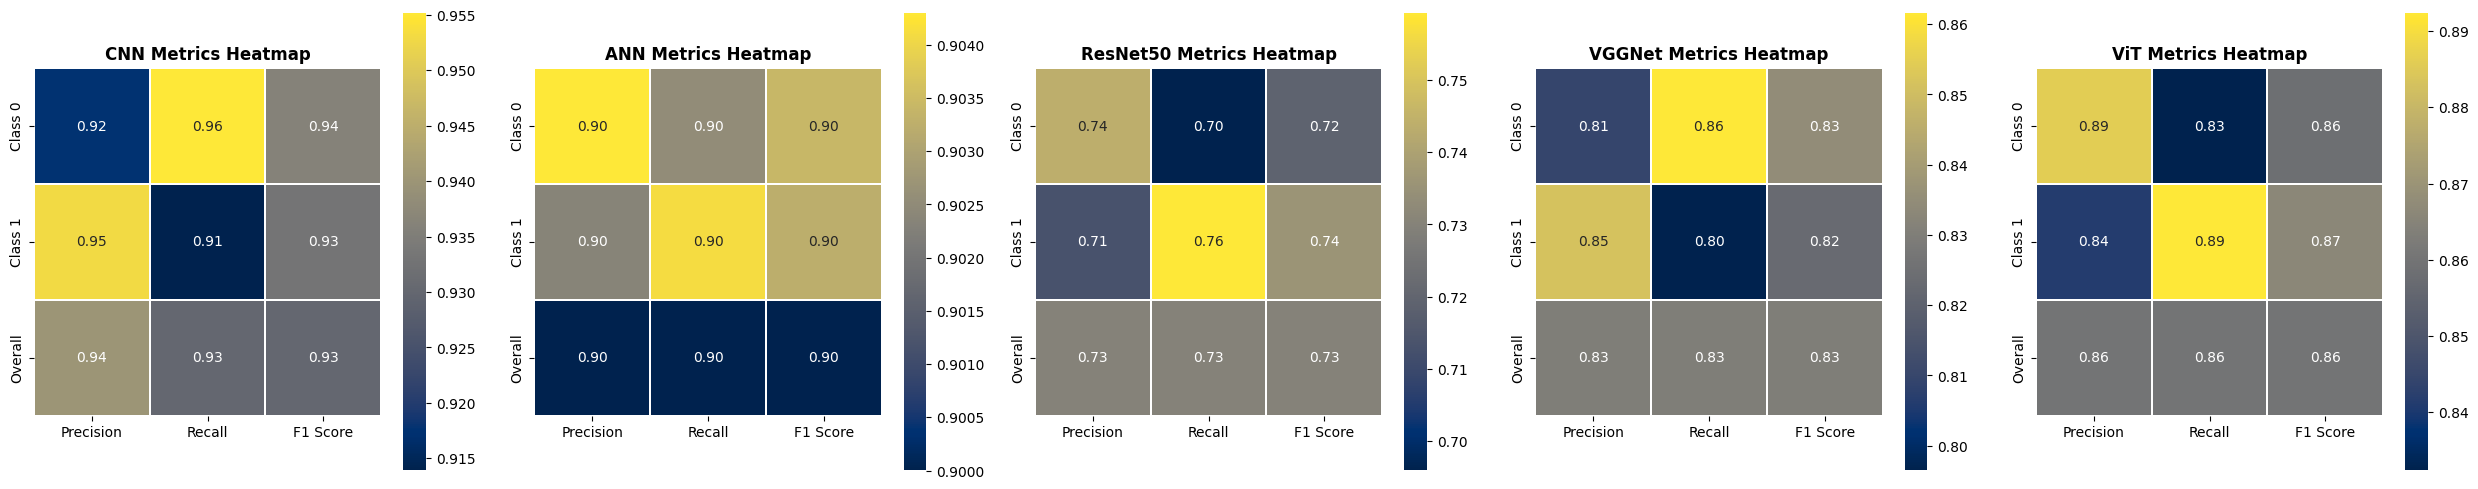

In [ ]:
# Create a 1x5 grid layout for heatmaps
plt.figure(figsize=(25, 5))

# CNN Heatmap
plt.subplot(1, 5, 1)
sns.heatmap(CNN_df, annot=True, fmt=".2f", cmap='cividis', cbar=True, square=True, linewidths=0.2)
plt.title("CNN Metrics Heatmap", fontweight='bold')

# ANN Heatmap
plt.subplot(1, 5, 2)
sns.heatmap(ANN_df, annot=True, fmt=".2f", cmap='cividis', cbar=True, square=True, linewidths=0.2)
plt.title("ANN Metrics Heatmap", fontweight='bold')

# ResNet Heatmap
plt.subplot(1, 5, 3)
sns.heatmap(RN_df, annot=True, fmt=".2f", cmap='cividis', cbar=True, square=True, linewidths=0.2)
plt.title("ResNet50 Metrics Heatmap", fontweight='bold')

# VGGNet Heatmap
plt.subplot(1, 5, 4)
sns.heatmap(VGG_df, annot=True, fmt=".2f", cmap='cividis', cbar=True, square=True, linewidths=0.2)
plt.title("VGGNet Metrics Heatmap", fontweight='bold')

# ViT Heatmap
plt.subplot(1, 5, 5)
sns.heatmap(ViT_df, annot=True, fmt=".2f", cmap='cividis', cbar=True, square=True, linewidths=0.2)
plt.title("ViT Metrics Heatmap", fontweight='bold')

# Adjust layout
plt.tight_layout()
plt.savefig('fig_18.png', format='png', dpi=300)
plt.show(block=False)

### Figures

In [ ]:
# Create a Zip file containing all the images
with zipfile.ZipFile('figures.zip', 'w') as zipf:
    zipf.write('fig_01.png')
    zipf.write('fig_02.png')
    zipf.write('fig_03.png')
    zipf.write('fig_04.png')
    zipf.write('fig_05.png')
    zipf.write('fig_06.png')
    zipf.write('fig_07.png')
    zipf.write('fig_08.png')
    zipf.write('fig_09.png')
    zipf.write('fig_10.png')
    zipf.write('fig_11.png')
    zipf.write('fig_12.png')
    zipf.write('fig_13.png')
    zipf.write('fig_14.png')
    zipf.write('fig_15.png')
    zipf.write('fig_16.png')
    zipf.write('fig_17.png')
    zipf.write('fig_18.png')

# Prompt the user for input
max_attempts = 3
attempts = 0

while attempts < max_attempts:
    download = input("Would you like to download the zip file of the graphs? (Y/N): ").strip().upper()
    if download == 'Y':
        files.download('figures.zip')
        break
    elif download == 'N':
        print("Download skipped.")
        break
    else:
        attempts += 1
        if attempts < max_attempts:
            print(f"Invalid input. Please enter 'Y' for Yes or 'N' for No. ({max_attempts - attempts} attempts remaining)")

if attempts == max_attempts:
    print("Maximum attempts reached. No action taken.")

Would you like to download the zip file of the graphs? (Y/N): Y


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

© 2025 Simone Castelli – All rights reserved.
This project is shared for viewing purposes only.  
You may not use, copy, modify, or distribute any part of this code without explicit permission.